**Phase 1: Baseline Implementation (Research Paper Reproduction)**

Resizing images


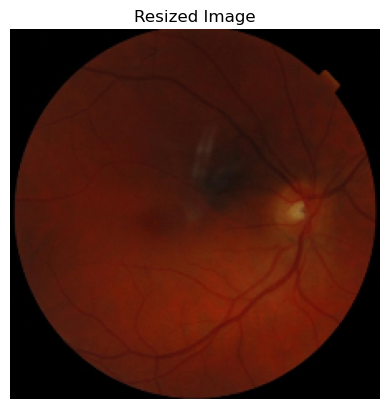

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

IMG_SIZE = 224
df = pd.read_csv('SmallData.csv')

def resize_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img_resized

sample_name = df['id_code'].iloc[0]
sample_path = os.path.join('images', sample_name)
resized_img = resize_image(sample_path)

plt.imshow(resized_img)
plt.title("Resized Image")
plt.axis('off')
plt.show()


Normalize Pixel Values

Pixel range after normalization: 0.0 - 0.6235294117647059


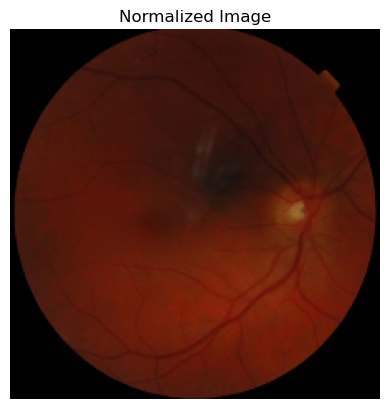

In [ ]:
import numpy as np

normalized_img = resized_img / 255.0

print("Pixel range after normalization:", normalized_img.min(), "-", normalized_img.max())
plt.imshow(normalized_img)
plt.title("Normalized Image")
plt.axis('off')
plt.show()


Erosion and Dilation

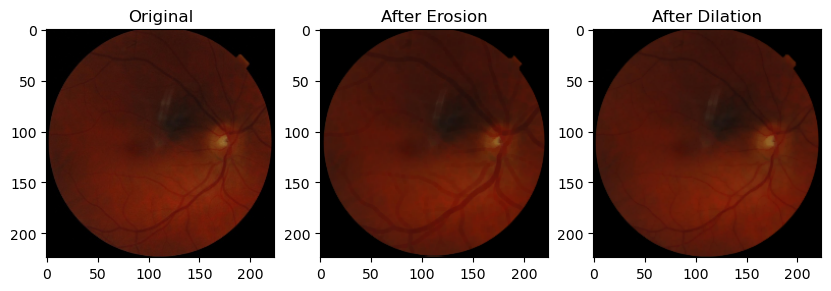

In [ ]:
# morphological preprocessing
kernel = np.ones((3,3), np.uint8)

# erosion
eroded_img = cv2.erode(resized_img, kernel, iterations=1)

# dilation
dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)


plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(resized_img)
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(eroded_img)
plt.title("After Erosion")

plt.subplot(1,3,3)
plt.imshow(dilated_img)
plt.title("After Dilation")
plt.show()


Train/Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

# we use diagnosis column as label
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

print("Training size:", len(train_df))
print("Validation size:", len(val_df))
print("Training label distribution:\n", train_df['diagnosis'].value_counts())
print("Validation label distribution:\n", val_df['diagnosis'].value_counts())


Training size: 568
Validation size: 142
Training label distribution:
 diagnosis
2    160
0    160
1    160
3     60
4     28
Name: count, dtype: int64
Validation label distribution:
 diagnosis
0    40
1    40
2    40
3    15
4     7
Name: count, dtype: int64


In [ ]:
# applying to all the images
import numpy as np
import cv2
import os
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 224  # same used in the research paper
NUM_CLASSES = 5

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # normalize
    img = img / 255.0

    kernel = np.ones((3, 3), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)

    return img


In [ ]:
 # load and preprocess all train/val Images
def load_dataset(df, image_dir):
    images = []
    labels = []

    for i in range(len(df)):
        img_name = df['id_code'].iloc[i]
        label = df['diagnosis'].iloc[i]
        img_path = os.path.join(image_dir, img_name)

        try:
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print("Skipping:", img_path, "| Error:", e)

    X = np.array(images)
    y = to_categorical(np.array(labels), num_classes=NUM_CLASSES)

    return X, y

# using existing train/val splits
image_dir = 'images'

X_train, y_train = load_dataset(train_df, image_dir)
X_val, y_val = load_dataset(val_df, image_dir)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)


Train shape: (568, 224, 224, 3) (568, 5)
Val shape: (142, 224, 224, 3) (142, 5)


# CNN Model from the Research Paper

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# set input shape based on your images
input_shape = (224, 224, 3)


build model layer by layer

In [ ]:
from tensorflow.keras import Input

model = Sequential()

# 1st later
model.add(Input(shape=(224, 224, 3)))

# continue with Conv2D
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))


compile model

In [ ]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,541 (42.64 MB)

 Trainable params: 11,177,541 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

# model training

In [ ]:
from tensorflow.keras.optimizers import Adam

# compile again to confirm
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    verbose=1
)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 640ms/step - accuracy: 0.2817 - loss: 1.5355 - val_accuracy: 0.2817 - val_loss: 1.4893
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 681ms/step - accuracy: 0.2993 - loss: 1.4553 - val_accuracy: 0.2746 - val_loss: 1.4723
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 690ms/step - accuracy: 0.3732 - loss: 1.4536 - val_accuracy: 0.3310 - val_loss: 1.4574
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 696ms/step - accuracy: 0.3539 - loss: 1.4245 - val_accuracy: 0.3521 - val_loss: 1.4198
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 680ms/step - accuracy: 0.4173 - loss: 1.3930 - val_accuracy: 0.3662 - val_loss: 1.4212
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 683ms/step - accuracy: 0.4102 - loss: 1.3712 - val_accuracy: 0.3873 - val_loss: 1.4245
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 683ms/step - accuracy: 0.4102 - loss: 1.3279 - val_accuracy: 0.2958 - val_loss: 1.3878
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 689ms/step - accuracy: 0.4489 - loss: 1.2947 - val_accu

# Evaluation and Visualization

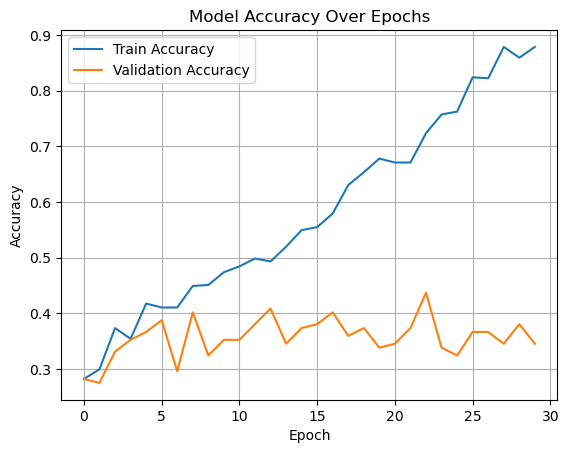

In [ ]:
# accuracy plot
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

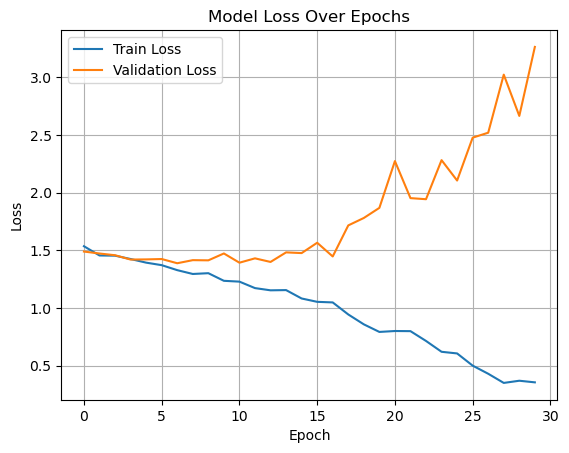

In [ ]:
# loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# final accuracy on validation set

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.3451 - loss: 3.2652
Validation Accuracy: 34.51%


In [ ]:
model.save("DR_detection_model.keras")


**Phase 2: Improvement by MobileNetV2 Attempt (Approach B)**

In [ ]:
import pandas as pd

df = pd.read_csv("labels.csv")

# Keep only gradable images
df = df[df['adjudicated_gradable'] == 1]

print("Usable images after filtering:", len(df))
df.head()


Usable images after filtering: 1744


,id_code,diagnosis,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0,0,1
1,20051020_43832_0100_PP.png,1,0,1
2,20051020_43882_0100_PP.png,1,0,1
3,20051020_43906_0100_PP.png,2,1,1
4,20051020_44261_0100_PP.png,0,0,1


In [ ]:
df = df[['id_code', 'diagnosis']]
print("Remaining columns:", df.columns)
print("Class distribution:\n", df['diagnosis'].value_counts())


Remaining columns: Index(['id_code', 'diagnosis'], dtype='object')
Class distribution:
 diagnosis
0    1017
2     347
1     270
3      75
4      35
Name: count, dtype: int64


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 224
image_dir = "img/"

X = []
y = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(image_dir, row['id_code'])

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    X.append(img)
    y.append(row['diagnosis'])

X = np.array(X)
y = np.array(y)

print("Final image shape:", X.shape)
print("Final labels shape:", y.shape)


100%|██████████| 1744/1744 [00:44<00:00, 39.21it/s]


Final image shape: (1744, 224, 224, 3)
Final labels shape: (1744,)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# one-hot encode labels
y_cat = to_categorical(y, num_classes=5)

# train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y)

# check shape and class balance
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Train label distribution:")
print(y_train.sum(axis=0))
print("\nValidation label distribution:")
print(y_val.sum(axis=0))


Train shape: (1395, 224, 224, 3) (1395, 5)
Validation shape: (349, 224, 224, 3) (349, 5)
Train label distribution:
[813. 216. 278.  60.  28.]

Validation label distribution:
[204.  54.  69.  15.   7.]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# no augmentaion for validation
val_datagen = ImageDataGenerator()

# generators
train_gen = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# load MobileNetV2 base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base

# custom layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs)

# compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# convert one-hot y_train back to class indices
y_train_labels = np.argmax(y_train, axis=1)

# compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.34317343173431736), 1: np.float64(1.2916666666666667), 2: np.float64(1.0035971223021583), 3: np.float64(4.65), 4: np.float64(9.964285714285714)}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)


C:\Users\v o s t r o\Documents\conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 808ms/step - accuracy: 0.2265 - loss: 1.9771 - val_accuracy: 0.2865 - val_loss: 1.5522
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 932ms/step - accuracy: 0.2272 - loss: 1.7858 - val_accuracy: 0.2579 - val_loss: 1.5544
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 932ms/step - accuracy: 0.2509 - loss: 1.6532 - val_accuracy: 0.3095 - val_loss: 1.5170
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 927ms/step - accuracy: 0.2330 - loss: 1.6301 - val_accuracy: 0.3897 - val_loss: 1.4412
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 807ms/step - accuracy: 0.2523 - loss: 1.5994 - val_accuracy: 0.4298 - val_loss: 1.4276
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 786ms/step - accuracy: 0.3176 - loss: 1.5056 - val_accuracy: 0.4298 - val_loss: 1.4070
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 777ms/step - accuracy: 0.2487 - loss: 1.5140 - val_accuracy: 0.4126 - val_loss: 1.4122
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 830ms/step - accuracy: 0.2989 - loss: 1.5039 - val_accu

In [ ]:
                                                                     # Unfreeze base model
base_model.trainable = True

# recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),  # smaller LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# num of layers we train
print("Number of trainable layers:", len(model.trainable_weights))


Number of trainable layers: 160


In [ ]:
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.3376 - loss: 1.6867 - val_accuracy: 0.5387 - val_loss: 1.2423
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.3269 - loss: 1.5611 - val_accuracy: 0.5330 - val_loss: 1.2293
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.3211 - loss: 1.5439 - val_accuracy: 0.5244 - val_loss: 1.2073
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.3233 - loss: 1.5029 - val_accuracy: 0.5186 - val_loss: 1.1961
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.3254 - loss: 1.4128 - val_accuracy: 0.5186 - val_loss: 1.1888


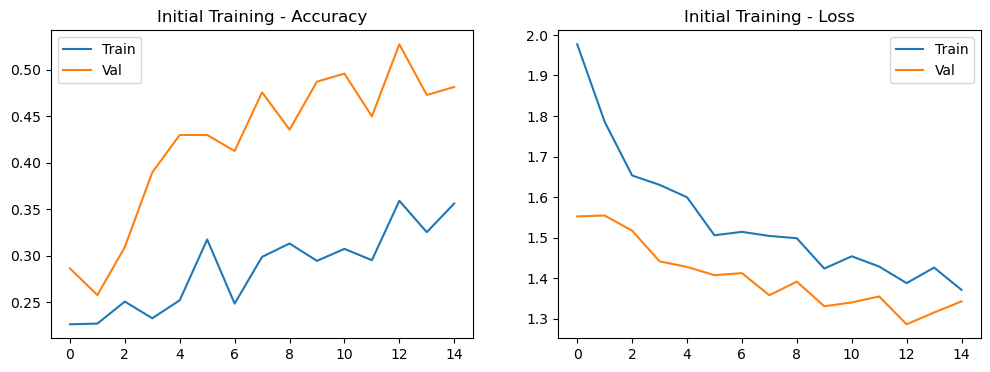

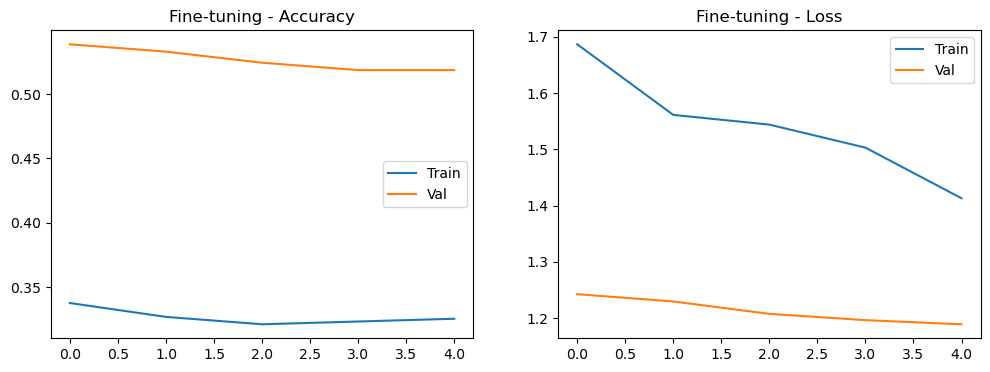

In [ ]:
import matplotlib.pyplot as plt

def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        plt.figure(figsize=(12, 4))

        # accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Val')
        plt.title(f'{title} - Accuracy')
        plt.legend()

        # loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Val')
        plt.title(f'{title} - Loss')
        plt.legend()

        plt.show()

plot_history([history, fine_tune_history], ['Initial Training', 'Fine-tuning'])


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 478ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.66      0.67       204
           1       0.24      0.15      0.18        54
           2       0.31      0.51      0.38        69
           3       1.00      0.13      0.24        15
           4       0.33      0.14      0.20         7

    accuracy                           0.52       349
   macro avg       0.51      0.32      0.34       349
weighted avg       0.55      0.52      0.51       349



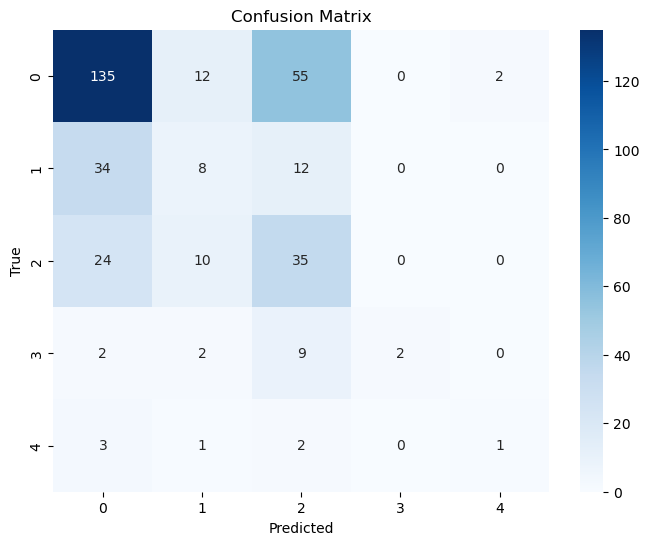

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# predit
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# report
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Watch validation loss
    factor=0.5,             # Halve the learning rate
    patience=2,             # Wait 2 epochs before reducing
    min_lr=1e-7,            # Smallest possible LR
    verbose=1
)


In [ ]:
fine_tune_history_v2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4086 - loss: 0.1597 - val_accuracy: 0.5759 - val_loss: 0.1556 - learning_rate: 5.0000e-05
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4167 - loss: 0.1482  
Epoch 2: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4538 - loss: 0.1357 - val_accuracy: 0.5673 - val_loss: 0.1614 - learning_rate: 5.0000e-05
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.4509 - loss: 0.1351 - val_accuracy: 0.5702 - val_loss: 0.1676 - learning_rate: 2.5000e-05


In [ ]:
import numpy as np

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.96      0.74       204
           1       0.12      0.04      0.06        54
           2       0.33      0.03      0.05        69
           3       0.00      0.00      0.00        15
           4       1.00      0.14      0.25         7

    accuracy                           0.58       349
   macro avg       0.41      0.23      0.22       349
weighted avg       0.46      0.58      0.46       349



C:\Users\v o s t r o\Documents\conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\v o s t r o\Documents\conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\v o s t r o\Documents\conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input

# Input layer
input_layer = Input(shape=(224, 224, 3))

# Load MobileNetV2 without top classifier
base_model = MobileNetV2(input_tensor=input_layer, include_top=False, weights='imagenet')
base_model.trainable = False  # We’ll unfreeze later during fine-tuning


C:\Users\v o s t r o\AppData\Local\Temp\ipykernel_18824\1820262384.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_layer, include_top=False, weights='imagenet')


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Base output
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Dense Block 1
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Dense Block 2
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
output = Dense(5, activation='softmax')(x)

# Final model
model = Model(inputs=input_layer, outputs=output)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)


In [ ]:
history_hybrid = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.2072 - loss: 0.6272 - val_accuracy: 0.1605 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.2151 - loss: 0.5493 - val_accuracy: 0.2722 - val_loss: 0.2587 - learning_rate: 1.0000e-04
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.2308 - loss: 0.5078 - val_accuracy: 0.3496 - val_loss: 0.2323 - learning_rate: 1.0000e-04
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2566 - loss: 0.4635 - val_accuracy: 0.3639 - val_loss: 0.2235 - learning_rate: 1.0000e-04
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2473 - loss: 0.5080 - val_accuracy: 0.4155 - val_loss: 0.2055 - learning_rate: 1.0000e-04
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2387 - loss: 0.4941 - val_accuracy: 0.4957 - val_loss: 0.1862 - learning_rate: 1.0000e-04
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2487 - loss:

In [ ]:
import numpy as np

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 842ms/step


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       204
           1       0.26      0.22      0.24        54
           2       0.27      0.19      0.22        69
           3       0.18      0.47      0.26        15
           4       0.17      0.43      0.24         7

    accuracy                           0.50       349
   macro avg       0.31      0.40      0.33       349
weighted avg       0.51      0.50      0.50       349



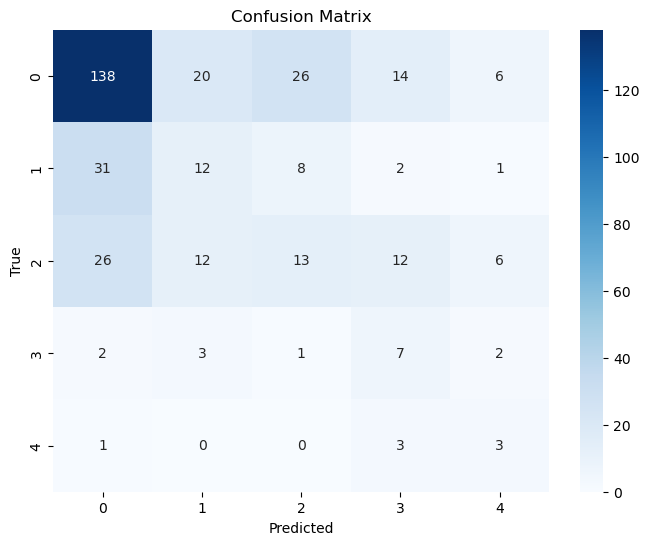

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
my_model=model.save("DR_mobilenetv2.keras")


**Phase 3: Hybrid Approach**(CNN classifier head on top+MobileNetV2 as frozen base)

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    # Watch validation loss
    monitor='val_loss',
    # reduce alpha by half
    factor=0.5,
    # we wait 2 epochs befor reducing
    patience=2,
     # smallest poddible lr
    min_lr=1e-7,
    verbose=1
)


In [ ]:
fine_tune_history_v2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4086 - loss: 0.1597 - val_accuracy: 0.5759 - val_loss: 0.1556 - learning_rate: 5.0000e-05
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4167 - loss: 0.1482  
Epoch 2: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4538 - loss: 0.1357 - val_accuracy: 0.5673 - val_loss: 0.1614 - learning_rate: 5.0000e-05
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.4509 - loss: 0.1351 - val_accuracy: 0.5702 - val_loss: 0.1676 - learning_rate: 2.5000e-05


In [ ]:
import numpy as np

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.96      0.74       204
           1       0.12      0.04      0.06        54
           2       0.33      0.03      0.05        69
           3       0.00      0.00      0.00        15
           4       1.00      0.14      0.25         7

    accuracy                           0.58       349
   macro avg       0.41      0.23      0.22       349
weighted avg       0.46      0.58      0.46       349



C:\Users\v o s t r o\Documents\conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\v o s t r o\Documents\conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\v o s t r o\Documents\conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input

# input layer
input_layer = Input(shape=(224, 224, 3))

# load MobileNetV2 without top classifier
base_model = MobileNetV2(input_tensor=input_layer, include_top=False, weights='imagenet')
base_model.trainable = False


C:\Users\v o s t r o\AppData\Local\Temp\ipykernel_18824\1820262384.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_layer, include_top=False, weights='imagenet')


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# base output
x = base_model.output
x = GlobalAveragePooling2D()(x)

# dense block 1
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# dense block 2
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# output layer
output = Dense(5, activation='softmax')(x)

# final model
model = Model(inputs=input_layer, outputs=output)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)


In [ ]:
history_hybrid = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.2072 - loss: 0.6272 - val_accuracy: 0.1605 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.2151 - loss: 0.5493 - val_accuracy: 0.2722 - val_loss: 0.2587 - learning_rate: 1.0000e-04
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.2308 - loss: 0.5078 - val_accuracy: 0.3496 - val_loss: 0.2323 - learning_rate: 1.0000e-04
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2566 - loss: 0.4635 - val_accuracy: 0.3639 - val_loss: 0.2235 - learning_rate: 1.0000e-04
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2473 - loss: 0.5080 - val_accuracy: 0.4155 - val_loss: 0.2055 - learning_rate: 1.0000e-04
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2387 - loss: 0.4941 - val_accuracy: 0.4957 - val_loss: 0.1862 - learning_rate: 1.0000e-04
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2487 - loss:

In [ ]:
import numpy as np

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 842ms/step


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       204
           1       0.26      0.22      0.24        54
           2       0.27      0.19      0.22        69
           3       0.18      0.47      0.26        15
           4       0.17      0.43      0.24         7

    accuracy                           0.50       349
   macro avg       0.31      0.40      0.33       349
weighted avg       0.51      0.50      0.50       349



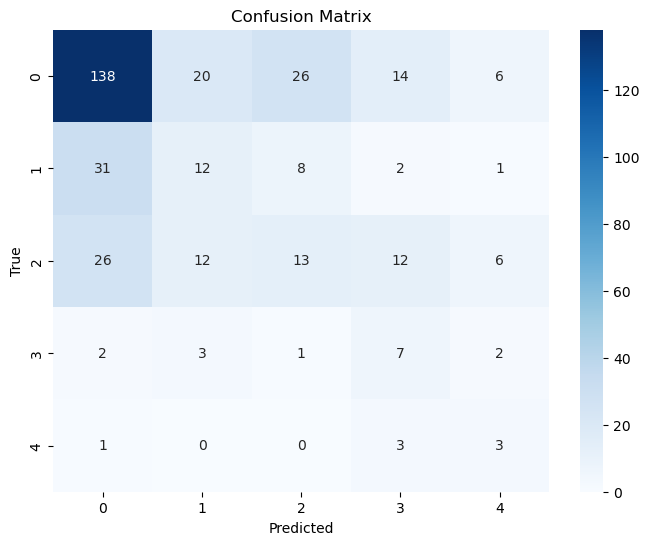

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
